# Dempster-Shafer Inference Algorithm


In [1]:
from datetime import datetime
import os
import time
import pandas as pd
import numpy as np
import sys

# Adjust the path to include the directory where config.py is located
sys.path.insert(0, "../src")

from config.config import *
from DS import DempsterShafer
from utilities.data_process.csv_formatter import CSVDataFormatter
from utilities.data_process.time_functions import *

# from utilities.data_process.DSI_data_preparation import *
from hypotheses_manager import HypothesesManager
from utilities.feature_manager import FeatureMatrixManager
from utilities.sampling_manager import SamplingMatrixManager

## Process data


In [ ]:
test_name = "multiple_test_ID0_10-18_30-4"
fault = "Multiple"

In [ ]:
test_cases = {
    "Normal operation": [
        [["S1", "S2", "S3", "S4"], ["29-04-2024 01:00:00", "29-04-2024 01:30:00"]]
    ],
    "Voltage 3.5V": [[["S1"], ["29-04-2024 01:30:00", "29-04-2024 02:00:00"]]],
    "Voltage 3.8V": [[["S1"], ["29-04-2024 02:00:00", "29-04-2024 02:20:00"]]],
    "Voltage 4.0V": [[["S1"], ["29-04-2024 02:25:00", "29-04-2024 02:40:00"]]],
    "Voltage 4.2V": [
        # [["S1"], ["29-04-2024 02:30:00", "29-04-2024 03:00:00"]],
        [["S1"], ["29-04-2024 02:40:00", "29-04-2024 03:00:00"]],
    ],
    "Overheat": [[["S3"], ["29-04-2024 02:10:00", "29-04-2024 03:00:00"]]],
    "Aerosol": [
        [["S4"], ["29-04-2024 02:25:00", "29-04-2024 02:45:00"]],
    ],
    "Overheat and Voltage 3.5V": [
        [["S1"], ["29-04-2024 03:00:00", "29-04-2024 03:20:00"]],
    ],
    "Overheat and Voltage 3.8V": [
        [["S1"], ["29-04-2024 03:20:00", "29-04-2024 03:40:00"]],
    ],
    "Aerosol and Voltage 3.5V": [
        [["S1"], ["29-04-2024 04:00:00", "29-04-2024 04:20:00"]],
    ],
    "Aerosol and Voltage 3.8V": [
        [["S1"], ["29-04-2024 03:45:00", "29-04-2024 04:00:00"]],
    ],
    "Communication": [[[None], [None, None]]],
    # "Uncertain": [[[None], [None, None]]],
}

sampling = [["S1", "S2", "S3", "S4"], ["28-04-2024 21:00:00", "28-04-2024 23:02:00"]]

is_uncertain = False
uncertain_hypothsis = "Uncertain"
if uncertain_hypothsis in list(test_cases.keys()):
    is_uncertain = True

DSI_hypotheses = HypothesesManager(hypothesis_list=hypotheses)
DSI_hypotheses.populate_info("time", test_cases)
DSI_hypotheses.populate_info("color", hypotheses_colors)
DSI_hypotheses.activation("time")
print(DSI_hypotheses.test_hypotheses)
print(DSI_hypotheses.extract_values("time"))
print("Here", DSI_hypotheses.get_hypotheses_info("time"))
print("Here", DSI_hypotheses.get_hypotheses_info("color"))

### Feature matrix


In [ ]:
# print(DSI_hypotheses.get_hypotheses_info("time"))

feat_matrix_manager = FeatureMatrixManager(DSI_hypotheses.get_hypotheses_info("time"))
hypotheses_names = DSI_hypotheses.get_feature_mat_hypothesis()
print(hypotheses_names)
# csv_file_dir = "../data/{}/processed"
feat_matrix_manager.process_hypotheses(
    hypotheses_names, csv_file_dir, parameters=parameter_headers
)

In [ ]:
# Loss of communication
small_number = 10e-6  # Define the small number you want to use

feat_mat_fault_com = np.full((1, len(parameter_headers)), small_number)
feat_matrix_manager.input_feature_vector("Communication", feat_mat_fault_com)

### Final feature matrix


In [ ]:

feat_mat = feat_matrix_manager.get_features_matrix()
print("Feature matrix: ", feat_mat)
# print("Shape of Feature matrix: ", feat_mat.shape[0])

### Sampling data


#### Sampling data


In [ ]:

csv_file_dir = "../data/{}/raw"
samp_mat_manager = SamplingMatrixManager(sampling)
samp_mat_manager.process_hypotheses(csv_file_dir, parameter_headers)
# print(samp_mat_manager.get_sampling_matrix())
sampling_matrix = samp_mat_manager.get_sampling_matrix()
# print("Sampling Matrix", sampling_matrix)
sampling_indexes = samp_mat_manager.get_sampling_indexes()
# print("Sampling Matrix Shape", indexes["S1"])
# print("Sampling Matrix Shape", indexes["S1"])

## DSI


### Initialization


In [ ]:

test_hypotheses = DSI_hypotheses.get_test_hypotheses()
sampling_freq = [1]
print(test_hypotheses)


### Execution


In [14]:
import pandas as pd

# Step 1: Read and extract specific columns from the feature matrix CSV file
feature_matrix_file = "../data/aqms/processed/aqms_1141_processed.csv"
feature_columns = [
    "HUMID",
    "TEMP",
    "PM2.5",
    "PM10",
]  # Specify the columns you want to extract
feature_df = pd.read_csv(feature_matrix_file)
start_time_feat = "01-01-2023 01:00:00"  # Start time for sampling matrix
end_time_feat = "01-06-2021 00:00:00"  # End time for sampling matrix
feature_df = feature_df[feature_columns][
    (feature_df["timestamp"] >= convert_to_unix(start_time_feat))
    & (feature_df["timestamp"] <= convert_to_unix(end_time_feat))
]
print(feature_df)

       HUMID    TEMP   PM2.5    PM10
4344  94.182  14.430   9.468  13.156
4345  94.633  14.242  12.062  15.568
4346  95.435  13.524  11.075  10.536
4347  95.912  13.402  14.160  13.571
4348  96.170  12.879  12.439  11.287
...      ...     ...     ...     ...
5083  81.790  11.214   6.579  23.518
5084  85.524  10.409   8.949  32.624
5085  85.155  10.212  15.334  30.450
5086  86.655   9.458  15.695  30.528
5087  88.392   8.952  17.568  32.213

[744 rows x 4 columns]


In [17]:
import pandas as pd
# Step 2: Read and extract specific rows between two timestamps from the sampling matrix CSV file
sampling_matrix_file = (
    "../data/purpleair_data_csv-20240424T011109Z-001/purpleair_data_csv/91355.csv"
)
start_time_samp = "01-05-2021 00:00:00"  # Start time for sampling matrix
end_time_samp = "31-05-2021 23:59:00"  # End time for sampling matrix
sampling_df = pd.read_csv(sampling_matrix_file)
sampling_df = sampling_df.sort_values(by=["time_stamp"], ascending=True, ignore_index=True)
samp_columns = [
    "humidity",
    "temperature",
    "pm2.5_alt",
    "pm10.0_atm",
]
print(type(convert_to_unix(start_time_samp)))
print(sampling_df["time_stamp"])
# Filter rows between start_time and end_time
sampling_df = sampling_df[samp_columns][
    (sampling_df["time_stamp"] >= convert_to_unix(start_time_samp))
    & (sampling_df["time_stamp"] <= convert_to_unix(end_time_samp))
]
sampling_df.loc[sampling_df["temperature"] != 0, "temperature"] = (
    (sampling_df.loc[sampling_df["temperature"] != 0, "temperature"] - 32) * 5 / 9
)
print(sampling_df)
start_datetime = datetime.strptime(start_time_samp, "%d-%m-%Y %H:%M:%S")
end_datetime = datetime.strptime(end_time_samp, "%d-%m-%Y %H:%M:%S")
date_range = pd.date_range(start=start_datetime, end=end_datetime, freq='10min')
print(date_range)


<class 'int'>
0         1605891000
1         1605891600
2         1605892200
3         1605892800
4         1605893400
             ...    
111285    1680613800
111286    1680614400
111287    1680615000
111288    1680615600
111289    1680616200
Name: time_stamp, Length: 111290, dtype: int64
       humidity  temperature  pm2.5_alt  pm10.0_atm
11220      74.0    16.666667        8.9      15.743
11221      74.0    16.666667       10.0      17.574
11222      74.2    16.666667       10.4      18.367
11223      74.0    16.666667       11.0      19.459
11224      74.4    16.444444       12.9      23.321
...         ...          ...        ...         ...
15679      72.0    10.555556       15.1      31.542
15680      72.0    10.555556       14.9      31.233
15681      72.0    10.555556       14.2      30.329
15682      72.0    10.555556       13.3      27.882
15683      72.0    10.555556       13.1      27.454

[4464 rows x 4 columns]
DatetimeIndex(['2021-05-01 00:00:00', '2021-05-01 00:10:00'

In [18]:
import numpy as np
test_hypotheses = ["Normal operation", "Aerosol", "Uncertain"]
sampling_freq = [1]
DSI_results = {}
DSI_results['91355'] = pd.DataFrame()
is_uncertain = True
count = 0
# Loop through each row of the feature matrix
for index, feature_row in feature_df.iterrows():
    # print(feature_row)
    # Get the relevant sampling matrix data for the current feature row
    print("index", count)
    sampling_rows = sampling_df.iloc[count * 6 : (count + 1) * 6]
    # print(sampling_df.iloc[count * 6 : (count + 1) * 6 - 1])
    count += 1
    for i, sampling_row in sampling_rows.iterrows():
        # Loop through each frequency in the sampling matrix
        # for freq, freq_data in data.items():
        #     if freq_data.empty:
        #         continue  # Skip empty data

        # Convert the sampling matrix data to numpy array
        sampling_mat = sampling_row.to_numpy().reshape(1,-1)
        # print("Samp", sampling_mat)
        feat_mat = feature_row.to_numpy().reshape(1,-1)
        # Create a new numpy array
        new_array = np.array([[65.2, 23.1, 200, 300]])

        # Add the new array to feat_mat
        feat_mat = np.vstack((feat_mat, new_array))
        
        # print("Feat", feat_mat)
        # Run Dempster-Shafer analysis
        ds = DempsterShafer(feat_mat, sampling_mat, is_uncertain=is_uncertain)
        ds.hypothesis_order(test_hypotheses)
        reliability = ds.result()
        # print(reliability)
        # Concatenate the reliability results for the current freq to its DataFrame
        DSI_results["91355"] = pd.concat(
            [DSI_results["91355"], reliability],
            axis=0,
            ignore_index=True,
        )

print(DSI_results)

index 0
       humidity  temperature  pm2.5_alt  pm10.0_atm
11220      74.0    16.666667        8.9      15.743
11221      74.0    16.666667       10.0      17.574
11222      74.2    16.666667       10.4      18.367
11223      74.0    16.666667       11.0      19.459
11224      74.4    16.444444       12.9      23.321
index 1
       humidity  temperature  pm2.5_alt  pm10.0_atm
11226      75.0    16.666667       12.5      22.566
11227      74.2    16.444444       12.7      22.328
11228      75.0    16.111111       13.4      24.628
11229      75.2    16.111111       14.1      24.857
11230      75.8    16.111111       14.5      25.402
index 2
       humidity  temperature  pm2.5_alt  pm10.0_atm
11232      74.8    15.888889       14.1      25.255
11233      74.8    15.555556       13.2      23.690
11234      74.2    15.555556       13.9      25.097
11235      75.0    15.555556       13.9      25.262
11236      75.8    15.555556       14.6      26.085
index 3
       humidity  temperature  pm

#### Legacy

In [ ]:
# from itertools import islice

# DSI_results = {}

# for sensor, data in sampling_matrix.items():
#     print("AA", sensor)
#     # print(data)
#     for freq in sampling_freq:
#         DSI_results[f"{sensor}_{freq}"] = (
#             pd.DataFrame()
#         )  # Adjusted to include freq in key
#         for i in range(0, len(data), freq):
#             if i + freq > len(data):  # Check to avoid index out of range
#                 break
#             sampling_rows = data[
#                 i : i + freq
#             ]  # Select the desired number of rows based on freq
#             # sampling_mat = sampling_rows.reshape((freq, len(parameter_headers)))  # Adjust reshape according to freq
#             sampling_mat = sampling_rows.to_numpy()
#             # print("Sampling Matrix", sampling_mat)
#             ds = DempsterShafer(feat_mat, sampling_mat, is_uncertain=is_uncertain)
#             ds.hypothesis_order(test_hypotheses)
#             reliability = ds.result()

#             # Concatenate the reliability results for the current freq to its DataFrame
#             DSI_results[f"{sensor}_{freq}"] = pd.concat(
#                 [DSI_results[f"{sensor}_{freq}"], reliability],
#                 axis=0,
#                 ignore_index=True,
#             )

# # print("AB", DSI_results['20240316_UTS1'])
# first_key = list(DSI_results.keys())[0]
# first_value = DSI_results[first_key]
# # print(first_key, first_value)
# print(DSI_results)

# Result visualization


In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from utilities.plot_functions import *

## Prepare result


## Reliability probability


### Initialization


In [20]:
sensor_colors = {"S1": "blue", "S2": "orange", "S3": "green", "S4": "red"}
# Define a color palette with 7 colors
# colors = sns.color_palette("Spectral", n_colors=7)
colors = [hypotheses_colors[hypothesis] for hypothesis in test_hypotheses]
print("Colors", colors)
indexes = date_range
print("Indexes", indexes)

Colors [(0.04359861591695502, 0.4648212226066897, 0.20369088811995387), 'blue', 'lightgray']
Indexes DatetimeIndex(['2021-05-01 00:00:00', '2021-05-01 00:10:00',
               '2021-05-01 00:20:00', '2021-05-01 00:30:00',
               '2021-05-01 00:40:00', '2021-05-01 00:50:00',
               '2021-05-01 01:00:00', '2021-05-01 01:10:00',
               '2021-05-01 01:20:00', '2021-05-01 01:30:00',
               ...
               '2021-05-31 22:20:00', '2021-05-31 22:30:00',
               '2021-05-31 22:40:00', '2021-05-31 22:50:00',
               '2021-05-31 23:00:00', '2021-05-31 23:10:00',
               '2021-05-31 23:20:00', '2021-05-31 23:30:00',
               '2021-05-31 23:40:00', '2021-05-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')


#### Stacked plot for probability assignment


Min max 2021-05-01 00:00:00 2021-05-31 23:50:00


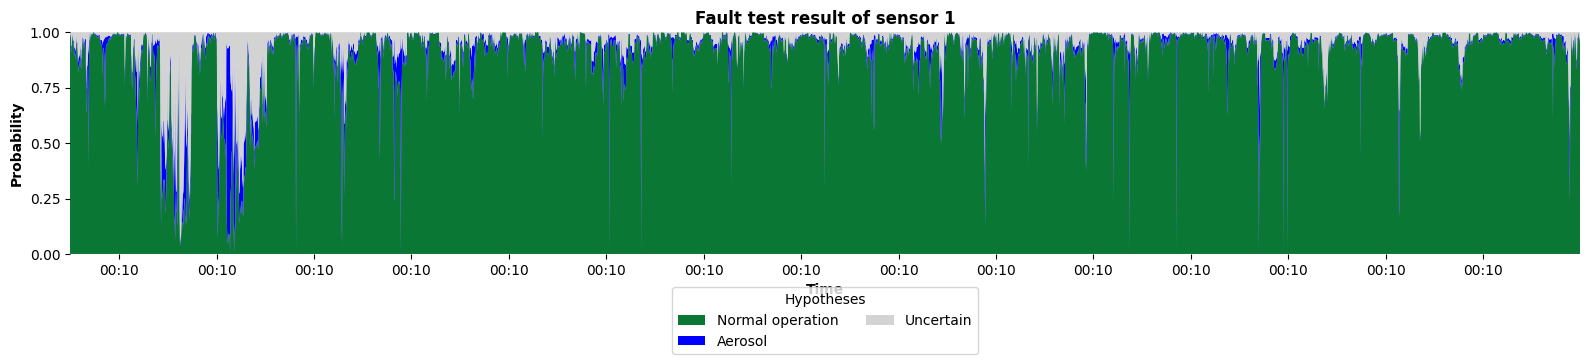

In [22]:
# Create subplots
# Determine number of subplots based on the number of items in DSI_results
n_subplots = len(DSI_results)
fig, axs = plt.subplots(n_subplots, 1, figsize=(16, 4 * n_subplots))
# Ensure `axs` is iterable (important if there's only one subplot)
if n_subplots == 1:
    axs = [axs]

count = 1
# print(DSI_results.items())
for ax, (key, value) in zip(axs, DSI_results.items()):
    plot_stacked_area_chart(ax, (key, value), indexes, colors, minute_locator=1440*2)
    ax.set_title(f"Fault test result of sensor {count}", fontweight="bold")
    ax.set_xlabel("Time", fontweight="bold")
    ax.set_ylabel("Probability", fontweight="bold")
    ax.margins(0.00,0.00)
    count += 1
# Remove spaces between subplots

# plt.subplots_adjust(hspace=0.2)

plt.legend(
    loc="center",
    bbox_to_anchor=(0.5, -0.3),
    title="Hypotheses",
    ncols=2,
)
# Show the plot
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.25)

# Save and show the figure
plt.show()
# fig.savefig(
#     f"../fig/Faults/Individual/S1/{fault}/DSI_results_{test_name}.png",
#     bbox_inches="tight",
# )


#### Line graph for normal operation probability


In [ ]:
# Prepare data for normal operation reliability plot
reliability_comparison = pd.DataFrame()
print(reliability_comparison)
for i, (sensor, data) in enumerate(DSI_results.items()):
    print("AA", sensor)
    reliability_comparison = pd.concat([reliability_comparison, data.iloc[:, 0]], axis=1)
    reliability_comparison = reliability_comparison.rename(columns={reliability_comparison.columns[-1]: f'{sensor[:-2]}'})

reliability_comparison = reliability_comparison.set_index(indexes)
reliability_comparison['Highest Reliability'] = reliability_comparison.idxmax(axis=1)
# print(reliability_comparison)

In [ ]:
fig, ax = plot_gantt_chart(
    reliability_comparison, "Highest Reliability", sensor_colors, minute_locator=10
)
# Modify the title using the Axes object
ax.set_title("Sensor switching schedule", fontweight="bold")
ax.set_xlabel("Time", fontweight="bold")
ax.set_ylabel("Sensor", fontweight="bold")
ax.margins(x=0.01,y=0.05)
# ax.legend(loc="upper left", ncol=1)
fig.show()
fig.savefig(
    f"../fig/Faults/Individual/S1/{fault}/switching_{test_name}.png",
    bbox_inches="tight",
)

In [ ]:
# Plot the reliability comparison
fig, ax = plot_line_graph_df(
    reliability_comparison,
    y_columns=reliability_comparison.columns[:-1],
    title="Reliability Comparison",
    xlabel="Time",
    ylabel="Reliability",
    color=list(sensor_colors.values()),
    figsize=(16, 4)
)
# Modify the title using the Axes object
ax.set_title("Probability of normal operation in dependable system")
ax.legend(loc="upper right", ncol=1)
fig.show()
fig.savefig(
    f"../fig/Faults/Individual/S1/{fault}/reliability_{test_name}.png",
    bbox_inches="tight",
)

#### Line graph for continuous data flow


In [ ]:
# Prepare data for continuous data flow
# Initialize an empty DataFrame to store the plot data
plot_data = pd.DataFrame()
# print("Plot data", plot_data)
# Iterate through each timestamp
for timestamp, row in reliability_comparison.iterrows():
    # print("Timestamp", timestamp)
    # print("Row", row)
    sensor = row["Highest Reliability"]
    # print("Sensor", sensor)
    sensor_data = sampling_matrix[sensor].loc[
        [timestamp]
    ]  # Use double brackets to keep DataFrame format
    # print("Sensor Data", sensor_data)
    plot_data = pd.concat([plot_data, sensor_data])
    # print("Plot data", plot_data)

# print("Plot data", plot_data)
colors = sns.color_palette("Spectral", n_colors=8)
fig, ax = plot_line_graph_df(
    plot_data,
    y_columns=["pm1.0_atm", "pm2.5_alt", "pm10.0_atm"],
    title="Continuous data stream",
    xlabel="Time",
    ylabel="Concentration (μg/m³)",
    color=colors,
    figsize=(16, 4),
)
# Modify the title using the Axes object
ax.legend(loc="upper right", ncol=1)
fig.show()
fig.savefig(
    f"../fig/Faults/Individual/S1/{fault}/datastream_{test_name}.png",
    bbox_inches="tight",
)